In [1]:
import os
import numpy as np
from _tools import load_data
from _tools import DSSClass

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
pwd = os.path.dirname(os.path.realpath('python'))
os.chdir(pwd)
master_path = os.path.abspath(os.path.join(pwd, 'LVTestCase/Master.dss'))
data_path = os.path.abspath(os.path.join(pwd, 'Daily_1min_100profiles'))
data = load_data(data_path)

dss = DSSClass(master_path)
dss.set_load_shapes(data, True)
os.chdir(pwd)

dss.solve()

> Initialising DSSClass
> Initialisation successful
> Loading circuit


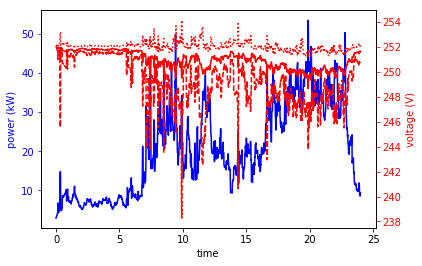

In [23]:
pq, vi = dss.get_monitor_data()

total_loads = np.array([l['S1 (kVA)'].as_matrix() for l in pq])
total_voltages = np.array([v['V1'].as_matrix() for v in vi])

total_load = np.sum(total_loads, 0)
v_mean = np.mean(total_voltages, 0)
v_min = np.max(total_voltages, 0)
v_max = np.min(total_voltages, 0)
t = np.arange(total_load.size) / 60.0

fig, ax1 = plt.subplots()
ax1.plot(t, total_load, 'b')
ax1.set_ylabel('power (kW)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xlabel('time')

ax2 = ax1.twinx()
ax2.plot(t, v_mean, 'r')
ax2.plot(t, v_max, 'r--')
ax2.plot(t, v_min, 'r:')
ax2.set_ylabel('voltage (V)', color='r')
ax2.tick_params('y', colors='r')

plt.show()